Convolutional Dictionary Learning
=================================

This example demonstrating the use of [dictlrn.DictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.dictlrn.html#sporco.dictlrn.dictlrn.DictLearn) to construct a dictionary learning algorithm with the flexibility of choosing the sparse coding and dictionary update classes. In this case they are [cbpdn.ConvBPDNGradReg](http://sporco.rtfd.org/en/latest/modules/sporco.admm.cbpdn.html#sporco.admm.cbpdn.ConvBPDNGradReg) and [admm.ccmod.ConvCnstrMOD](http://sporco.rtfd.org/en/latest/modules/sporco.admm.ccmod.html#sporco.admm.ccmod.ConvCnstrMOD) respectively, so the resulting dictionary learning algorithm is not equivalent to [dictlrn.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/modules/sporco.dictlrn.cbpdndl.html#sporco.dictlrn.cbpdndl.ConvBPDNDictLearn). Sparse coding with a CBPDN variant that includes a gradient regularization term on one of the coefficient maps [[52]](http://sporco.rtfd.org/en/latest/zreferences.html#id55) enables CDL without the need for the usual lowpass/highpass filtering as a pre-processing of the training images.

In [1]:
from __future__ import division
from __future__ import print_function
from builtins import input

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import cbpdn
from sporco.admm import ccmod
from sporco.dictlrn import dictlrn
from sporco import cnvrep
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.5, gray=True)
img1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
img2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
img3 = exim.image('monarch.png', idxexp=np.s_[:, 160:672])
S = np.stack((img1, img2, img3), axis=2)

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 64)

Construct object representing problem dimensions.

In [4]:
cri = cnvrep.CDU_ConvRepIndexing(D0.shape, S)

Set up weights for the $\ell_1$ norm to disable regularization of the coefficient map corresponding to the impulse filter.

In [5]:
wl1 = np.ones((1,)*4 + (D0.shape[2:]), dtype=np.float32)
wl1[..., 0] = 0.0

Set of weights for the $\ell_2$ norm of the gradient to disable regularization of all coefficient maps except for the one corresponding to the impulse filter.

In [6]:
wgr = np.zeros((D0.shape[2]), dtype=np.float32)
wgr[0] = 1.0

Define X and D update options.

In [7]:
lmbda = 0.1
mu = 0.5
optx = cbpdn.ConvBPDNGradReg.Options({'Verbose': False, 'MaxMainIter': 1,
            'rho': 20.0*lmbda + 0.5, 'AutoRho': {'Period': 10,
            'AutoScaling': False, 'RsdlRatio': 10.0, 'Scaling': 2.0,
            'RsdlTarget': 1.0}, 'HighMemSolve': True, 'AuxVarObj': False,
            'L1Weight': wl1, 'GradWeight': wgr})
optd = ccmod.ConvCnstrMODOptions({'Verbose': False, 'MaxMainIter': 1,
            'rho': 5.0*cri.K, 'AutoRho': {'Period': 10, 'AutoScaling': False,
            'RsdlRatio': 10.0, 'Scaling': 2.0, 'RsdlTarget': 1.0}},
            method='cns')

Normalise dictionary according to dictionary Y update options.

In [8]:
D0n = cnvrep.Pcn(D0, D0.shape, cri.Nv, dimN=2, dimC=0, crp=True,
                 zm=optd['ZeroMean'])

Update D update options to include initial values for Y and U.

In [9]:
optd.update({'Y0': cnvrep.zpad(cnvrep.stdformD(D0n, cri.Cd, cri.M), cri.Nv),
             'U0': np.zeros(cri.shpD + (cri.K,))})

Create X update object.

In [10]:
xstep = cbpdn.ConvBPDNGradReg(D0n, S, lmbda, mu, optx)

Create D update object.

In [11]:
dstep = ccmod.ConvCnstrMOD(None, S, D0.shape, optd, method='cns')

Create DictLearn object and solve.

In [12]:
opt = dictlrn.DictLearn.Options({'Verbose': True, 'MaxMainIter': 200})
d = dictlrn.DictLearn(xstep, dstep, opt)
D1 = d.solve()
print("DictLearn solve time: %.2fs" % d.timer.elapsed('solve'), "\n")

Itn   FncX      r_X       s_X       ρ_X       FncD      r_D       s_D       ρ_D     
------------------------------------------------------------------------------------


   0  7.30e+03  9.76e-01  1.03e-01  2.50e+00  1.64e+04  3.28e-01  2.20e-01  1.50e+01


   1  4.09e+03  4.54e-01  1.19e+00  2.50e+00  3.64e+04  3.86e-01  1.21e-01  1.50e+01


   2  5.30e+03  4.28e-01  8.99e-01  2.50e+00  6.12e+03  3.89e-01  1.71e-01  1.50e+01


   3  3.28e+03  3.40e-01  4.64e-01  2.50e+00  3.14e+03  3.67e-01  8.04e-02  1.50e+01


   4  2.01e+03  3.82e-01  6.02e-01  2.50e+00  8.88e+02  3.30e-01  8.14e-02  1.50e+01


   5  3.21e+03  3.96e-01  3.82e-01  2.50e+00  3.12e+03  2.64e-01  6.81e-02  1.50e+01


   6  2.44e+03  2.80e-01  3.85e-01  2.50e+00  5.56e+02  2.20e-01  6.41e-02  1.50e+01


   7  1.58e+03  1.95e-01  4.71e-01  2.50e+00  1.53e+03  1.81e-01  5.54e-02  1.50e+01


   8  2.52e+03  1.91e-01  1.82e-01  2.50e+00  1.22e+03  1.53e-01  5.40e-02  1.50e+01


   9  1.02e+03  1.78e-01  4.42e-01  2.50e+00  3.93e+02  1.29e-01  5.43e-02  1.50e+01


  10  1.90e+03  1.96e-01  1.88e-01  2.50e+00  1.12e+03  1.08e-01  5.47e-02  1.50e+01


  11  1.22e+03  1.37e-01  2.97e-01  2.50e+00  1.35e+02  9.16e-02  5.27e-02  1.50e+01


  12  1.39e+03  1.17e-01  2.27e-01  2.50e+00  7.79e+02  7.76e-02  5.40e-02  1.50e+01


  13  1.23e+03  1.10e-01  1.93e-01  2.50e+00  1.42e+02  6.67e-02  5.32e-02  1.50e+01


  14  9.07e+02  1.05e-01  2.29e-01  2.50e+00  4.18e+02  5.72e-02  5.05e-02  1.50e+01


  15  1.13e+03  9.59e-02  1.15e-01  2.50e+00  1.35e+02  5.12e-02  4.79e-02  1.50e+01


  16  6.80e+02  7.06e-02  1.87e-01  2.50e+00  2.43e+02  4.53e-02  4.47e-02  1.50e+01


  17  9.34e+02  7.06e-02  8.33e-02  2.50e+00  1.12e+02  4.06e-02  4.21e-02  1.50e+01


  18  5.22e+02  5.91e-02  1.50e-01  2.50e+00  1.52e+02  3.71e-02  4.21e-02  1.50e+01


  19  7.61e+02  5.80e-02  6.45e-02  2.50e+00  8.39e+01  3.41e-02  4.20e-02  1.50e+01


  20  4.60e+02  4.38e-02  1.14e-01  2.50e+00  1.06e+02  3.17e-02  4.10e-02  1.50e+01


  21  6.14e+02  4.26e-02  5.37e-02  2.50e+00  6.32e+01  2.94e-02  4.07e-02  1.50e+01


  22  4.28e+02  3.60e-02  8.19e-02  2.50e+00  8.21e+01  2.74e-02  4.03e-02  1.50e+01


  23  4.92e+02  3.35e-02  5.20e-02  2.50e+00  5.06e+01  2.57e-02  3.93e-02  1.50e+01


  24  4.16e+02  2.86e-02  5.83e-02  2.50e+00  6.41e+01  2.40e-02  3.78e-02  1.50e+01


  25  3.95e+02  2.55e-02  4.80e-02  2.50e+00  4.52e+01  2.23e-02  3.61e-02  1.50e+01


  26  3.94e+02  2.41e-02  3.89e-02  2.50e+00  5.30e+01  2.11e-02  3.46e-02  1.50e+01


  27  3.22e+02  2.03e-02  4.41e-02  2.50e+00  4.40e+01  1.99e-02  3.32e-02  1.50e+01


  28  3.58e+02  1.95e-02  2.84e-02  2.50e+00  4.60e+01  1.87e-02  3.20e-02  1.50e+01


  29  2.82e+02  1.65e-02  3.44e-02  2.50e+00  4.52e+01  1.77e-02  3.14e-02  1.50e+01


  30  3.18e+02  1.63e-02  2.52e-02  2.50e+00  4.41e+01  1.69e-02  3.08e-02  1.50e+01


  31  2.76e+02  1.48e-02  2.95e-02  2.50e+00  4.38e+01  1.61e-02  3.01e-02  1.50e+01


  32  2.82e+02  1.36e-02  2.27e-02  2.50e+00  4.24e+01  1.51e-02  2.93e-02  1.50e+01


  33  2.74e+02  1.29e-02  2.16e-02  2.50e+00  4.26e+01  1.44e-02  2.84e-02  1.50e+01


  34  2.58e+02  1.23e-02  2.33e-02  2.50e+00  4.12e+01  1.38e-02  2.74e-02  1.50e+01


  35  2.64e+02  1.17e-02  1.96e-02  2.50e+00  4.09e+01  1.32e-02  2.65e-02  1.50e+01


  36  2.48e+02  1.10e-02  1.93e-02  2.50e+00  4.09e+01  1.25e-02  2.56e-02  1.50e+01


  37  2.49e+02  1.07e-02  1.88e-02  2.50e+00  4.05e+01  1.20e-02  2.48e-02  1.50e+01


  38  2.43e+02  1.02e-02  1.82e-02  2.50e+00  4.05e+01  1.15e-02  2.41e-02  1.50e+01


  39  2.38e+02  9.67e-03  1.68e-02  2.50e+00  4.05e+01  1.10e-02  2.35e-02  1.50e+01


  40  2.37e+02  9.42e-03  1.64e-02  2.50e+00  4.04e+01  1.06e-02  2.30e-02  1.50e+01


  41  2.32e+02  9.15e-03  1.64e-02  2.50e+00  4.01e+01  1.03e-02  2.25e-02  1.50e+01


  42  2.31e+02  8.79e-03  1.51e-02  2.50e+00  3.99e+01  9.93e-03  2.20e-02  1.50e+01


  43  2.29e+02  8.54e-03  1.47e-02  2.50e+00  3.98e+01  9.46e-03  2.14e-02  1.50e+01


  44  2.26e+02  8.31e-03  1.46e-02  2.50e+00  3.95e+01  9.12e-03  2.09e-02  1.50e+01


  45  2.24e+02  8.02e-03  1.41e-02  2.50e+00  3.94e+01  8.92e-03  2.03e-02  1.50e+01


  46  2.22e+02  7.77e-03  1.36e-02  2.50e+00  3.94e+01  8.70e-03  1.98e-02  1.50e+01


  47  2.20e+02  7.59e-03  1.34e-02  2.50e+00  3.93e+01  8.37e-03  1.94e-02  1.50e+01


  48  2.18e+02  7.37e-03  1.30e-02  2.50e+00  3.92e+01  8.08e-03  1.90e-02  1.50e+01


  49  2.16e+02  7.17e-03  1.26e-02  2.50e+00  3.92e+01  7.90e-03  1.87e-02  1.50e+01


  50  2.15e+02  7.01e-03  1.25e-02  2.50e+00  3.91e+01  7.73e-03  1.84e-02  1.50e+01


  51  2.14e+02  6.86e-03  1.22e-02  2.50e+00  3.90e+01  7.52e-03  1.81e-02  1.50e+01


  52  2.12e+02  6.68e-03  1.19e-02  2.50e+00  3.89e+01  7.32e-03  1.78e-02  1.50e+01


  53  2.11e+02  6.54e-03  1.17e-02  2.50e+00  3.88e+01  7.25e-03  1.74e-02  1.50e+01


  54  2.10e+02  6.39e-03  1.15e-02  2.50e+00  3.87e+01  7.00e-03  1.71e-02  1.50e+01


  55  2.09e+02  6.26e-03  1.12e-02  2.50e+00  3.86e+01  6.84e-03  1.68e-02  1.50e+01


  56  2.08e+02  6.13e-03  1.09e-02  2.50e+00  3.86e+01  6.68e-03  1.65e-02  1.50e+01


  57  2.07e+02  6.01e-03  1.08e-02  2.50e+00  3.85e+01  6.58e-03  1.63e-02  1.50e+01


  58  2.05e+02  5.90e-03  1.06e-02  2.50e+00  3.85e+01  6.41e-03  1.60e-02  1.50e+01


  59  2.05e+02  5.77e-03  1.04e-02  2.50e+00  3.84e+01  6.30e-03  1.58e-02  1.50e+01


  60  2.04e+02  5.67e-03  1.02e-02  2.50e+00  3.84e+01  6.15e-03  1.56e-02  1.50e+01


  61  2.03e+02  5.57e-03  1.01e-02  2.50e+00  3.83e+01  6.09e-03  1.54e-02  1.50e+01


  62  2.02e+02  5.47e-03  9.91e-03  2.50e+00  3.83e+01  5.99e-03  1.52e-02  1.50e+01


  63  2.01e+02  5.38e-03  9.81e-03  2.50e+00  3.82e+01  5.89e-03  1.50e-02  1.50e+01


  64  2.00e+02  5.27e-03  9.59e-03  2.50e+00  3.81e+01  5.71e-03  1.48e-02  1.50e+01


  65  2.00e+02  5.19e-03  9.45e-03  2.50e+00  3.81e+01  5.66e-03  1.46e-02  1.50e+01


  66  1.99e+02  5.12e-03  9.39e-03  2.50e+00  3.81e+01  5.53e-03  1.45e-02  1.50e+01


  67  1.98e+02  5.03e-03  9.16e-03  2.50e+00  3.80e+01  5.49e-03  1.43e-02  1.50e+01


  68  1.98e+02  4.96e-03  9.09e-03  2.50e+00  3.80e+01  5.37e-03  1.42e-02  1.50e+01


  69  1.97e+02  4.89e-03  8.97e-03  2.50e+00  3.79e+01  5.29e-03  1.40e-02  1.50e+01


  70  1.96e+02  4.81e-03  8.81e-03  2.50e+00  3.79e+01  5.29e-03  1.39e-02  1.50e+01


  71  1.96e+02  4.75e-03  8.75e-03  2.50e+00  3.78e+01  5.16e-03  1.37e-02  1.50e+01


  72  1.95e+02  4.69e-03  8.69e-03  2.50e+00  3.78e+01  5.11e-03  1.36e-02  1.50e+01


  73  1.94e+02  4.62e-03  8.54e-03  2.50e+00  3.78e+01  5.02e-03  1.35e-02  1.50e+01


  74  1.94e+02  4.56e-03  8.41e-03  2.50e+00  3.77e+01  4.97e-03  1.34e-02  1.50e+01


  75  1.93e+02  4.51e-03  8.37e-03  2.50e+00  3.77e+01  4.92e-03  1.32e-02  1.50e+01


  76  1.93e+02  4.45e-03  8.26e-03  2.50e+00  3.76e+01  4.89e-03  1.31e-02  1.50e+01


  77  1.92e+02  4.40e-03  8.19e-03  2.50e+00  3.76e+01  4.80e-03  1.30e-02  1.50e+01


  78  1.92e+02  4.35e-03  8.10e-03  2.50e+00  3.76e+01  4.79e-03  1.29e-02  1.50e+01


  79  1.91e+02  4.30e-03  8.01e-03  2.50e+00  3.76e+01  4.72e-03  1.28e-02  1.50e+01


  80  1.91e+02  4.26e-03  7.97e-03  2.50e+00  3.75e+01  4.66e-03  1.27e-02  1.50e+01


  81  1.91e+02  4.22e-03  7.89e-03  2.50e+00  3.75e+01  4.64e-03  1.26e-02  1.50e+01


  82  1.90e+02  4.18e-03  7.82e-03  2.50e+00  3.75e+01  4.61e-03  1.25e-02  1.50e+01


  83  1.90e+02  4.15e-03  7.80e-03  2.50e+00  3.74e+01  4.56e-03  1.25e-02  1.50e+01


  84  1.89e+02  4.11e-03  7.75e-03  2.50e+00  3.74e+01  4.52e-03  1.24e-02  1.50e+01


  85  1.89e+02  4.07e-03  7.66e-03  2.50e+00  3.74e+01  4.50e-03  1.23e-02  1.50e+01


  86  1.89e+02  4.04e-03  7.65e-03  2.50e+00  3.73e+01  4.45e-03  1.22e-02  1.50e+01


  87  1.88e+02  4.01e-03  7.59e-03  2.50e+00  3.73e+01  4.44e-03  1.21e-02  1.50e+01


  88  1.88e+02  3.97e-03  7.50e-03  2.50e+00  3.73e+01  4.41e-03  1.20e-02  1.50e+01


  89  1.88e+02  3.94e-03  7.45e-03  2.50e+00  3.72e+01  4.36e-03  1.19e-02  1.50e+01


  90  1.87e+02  3.90e-03  7.37e-03  2.50e+00  3.72e+01  4.35e-03  1.18e-02  1.50e+01


  91  1.87e+02  3.87e-03  7.33e-03  2.50e+00  3.72e+01  4.38e-03  1.17e-02  1.50e+01


  92  1.86e+02  3.84e-03  7.35e-03  2.50e+00  3.72e+01  4.34e-03  1.17e-02  1.50e+01


  93  1.86e+02  3.82e-03  7.34e-03  2.50e+00  3.72e+01  4.25e-03  1.16e-02  1.50e+01


  94  1.86e+02  3.78e-03  7.26e-03  2.50e+00  3.71e+01  4.19e-03  1.15e-02  1.50e+01


  95  1.86e+02  3.74e-03  7.17e-03  2.50e+00  3.71e+01  4.22e-03  1.14e-02  1.50e+01


  96  1.85e+02  3.71e-03  7.16e-03  2.50e+00  3.71e+01  4.16e-03  1.13e-02  1.50e+01


  97  1.85e+02  3.69e-03  7.17e-03  2.50e+00  3.70e+01  4.17e-03  1.12e-02  1.50e+01


  98  1.85e+02  3.66e-03  7.11e-03  2.50e+00  3.70e+01  4.09e-03  1.11e-02  1.50e+01


  99  1.84e+02  3.63e-03  7.06e-03  2.50e+00  3.70e+01  4.13e-03  1.10e-02  1.50e+01


 100  1.84e+02  3.60e-03  7.04e-03  2.50e+00  3.70e+01  4.12e-03  1.10e-02  1.50e+01


 101  1.84e+02  3.57e-03  7.04e-03  2.50e+00  3.70e+01  4.03e-03  1.09e-02  1.50e+01


 102  1.83e+02  3.53e-03  6.93e-03  2.50e+00  3.69e+01  4.01e-03  1.08e-02  1.50e+01


 103  1.83e+02  3.50e-03  6.85e-03  2.50e+00  3.69e+01  3.96e-03  1.07e-02  1.50e+01


 104  1.83e+02  3.47e-03  6.86e-03  2.50e+00  3.69e+01  4.01e-03  1.06e-02  1.50e+01


 105  1.82e+02  3.44e-03  6.78e-03  2.50e+00  3.69e+01  3.91e-03  1.06e-02  1.50e+01


 106  1.82e+02  3.41e-03  6.75e-03  2.50e+00  3.69e+01  3.92e-03  1.05e-02  1.50e+01


 107  1.82e+02  3.39e-03  6.76e-03  2.50e+00  3.69e+01  3.86e-03  1.04e-02  1.50e+01


 108  1.82e+02  3.36e-03  6.69e-03  2.50e+00  3.68e+01  3.83e-03  1.04e-02  1.50e+01


 109  1.81e+02  3.33e-03  6.65e-03  2.50e+00  3.68e+01  3.85e-03  1.03e-02  1.50e+01


 110  1.81e+02  3.32e-03  6.69e-03  2.50e+00  3.68e+01  3.77e-03  1.03e-02  1.50e+01


 111  1.81e+02  3.28e-03  6.58e-03  2.50e+00  3.68e+01  3.78e-03  1.02e-02  1.50e+01


 112  1.80e+02  3.25e-03  6.47e-03  2.50e+00  3.68e+01  3.76e-03  1.01e-02  1.50e+01


 113  1.80e+02  3.23e-03  6.50e-03  2.50e+00  3.68e+01  3.76e-03  1.01e-02  1.50e+01


 114  1.80e+02  3.21e-03  6.51e-03  2.50e+00  3.67e+01  3.79e-03  1.00e-02  1.50e+01


 115  1.80e+02  3.19e-03  6.45e-03  2.50e+00  3.67e+01  3.74e-03  9.97e-03  1.50e+01


 116  1.79e+02  3.17e-03  6.46e-03  2.50e+00  3.67e+01  3.70e-03  9.91e-03  1.50e+01


 117  1.79e+02  3.15e-03  6.42e-03  2.50e+00  3.67e+01  3.69e-03  9.86e-03  1.50e+01


 118  1.79e+02  3.11e-03  6.31e-03  2.50e+00  3.67e+01  3.71e-03  9.81e-03  1.50e+01


 119  1.79e+02  3.09e-03  6.30e-03  2.50e+00  3.67e+01  3.67e-03  9.76e-03  1.50e+01


 120  1.79e+02  3.09e-03  6.36e-03  2.50e+00  3.67e+01  3.70e-03  9.71e-03  1.50e+01


 121  1.78e+02  3.06e-03  6.29e-03  2.50e+00  3.67e+01  3.58e-03  9.67e-03  1.50e+01


 122  1.78e+02  3.03e-03  6.19e-03  2.50e+00  3.66e+01  3.62e-03  9.62e-03  1.50e+01


 123  1.78e+02  3.03e-03  6.26e-03  2.50e+00  3.66e+01  3.56e-03  9.58e-03  1.50e+01


 124  1.78e+02  3.00e-03  6.18e-03  2.50e+00  3.66e+01  3.76e-03  9.53e-03  1.50e+01


 125  1.78e+02  2.98e-03  6.11e-03  2.50e+00  3.66e+01  3.72e-03  9.48e-03  1.50e+01


 126  1.77e+02  2.97e-03  6.16e-03  2.50e+00  3.66e+01  3.79e-03  9.43e-03  1.50e+01


 127  1.77e+02  2.95e-03  6.13e-03  2.50e+00  3.66e+01  3.87e-03  9.37e-03  1.50e+01


 128  1.77e+02  2.92e-03  6.02e-03  2.50e+00  3.66e+01  3.75e-03  9.32e-03  1.50e+01


 129  1.77e+02  2.90e-03  6.00e-03  2.50e+00  3.66e+01  3.76e-03  9.26e-03  1.50e+01


 130  1.77e+02  2.90e-03  6.10e-03  2.50e+00  3.66e+01  3.66e-03  9.22e-03  1.50e+01


 131  1.76e+02  2.89e-03  6.11e-03  2.50e+00  3.65e+01  3.58e-03  9.18e-03  1.50e+01


 132  1.76e+02  2.86e-03  6.02e-03  2.50e+00  3.65e+01  3.38e-03  9.14e-03  1.50e+01


 133  1.76e+02  2.84e-03  5.95e-03  2.50e+00  3.65e+01  3.37e-03  9.10e-03  1.50e+01


 134  1.76e+02  2.83e-03  5.98e-03  2.50e+00  3.65e+01  3.41e-03  9.06e-03  1.50e+01


 135  1.76e+02  2.82e-03  6.00e-03  2.50e+00  3.65e+01  3.41e-03  9.02e-03  1.50e+01


 136  1.75e+02  2.78e-03  5.82e-03  2.50e+00  3.65e+01  3.33e-03  8.99e-03  1.50e+01


 137  1.75e+02  2.76e-03  5.77e-03  2.50e+00  3.65e+01  3.34e-03  8.95e-03  1.50e+01


 138  1.75e+02  2.77e-03  5.88e-03  2.50e+00  3.65e+01  3.32e-03  8.92e-03  1.50e+01


 139  1.75e+02  2.75e-03  5.79e-03  2.50e+00  3.64e+01  3.45e-03  8.88e-03  1.50e+01


 140  1.75e+02  2.73e-03  5.75e-03  2.50e+00  3.64e+01  3.42e-03  8.84e-03  1.50e+01


 141  1.75e+02  2.73e-03  5.82e-03  2.50e+00  3.64e+01  3.27e-03  8.79e-03  1.50e+01


 142  1.74e+02  2.70e-03  5.68e-03  2.50e+00  3.64e+01  3.26e-03  8.74e-03  1.50e+01


 143  1.74e+02  2.67e-03  5.60e-03  2.50e+00  3.64e+01  3.32e-03  8.69e-03  1.50e+01


 144  1.74e+02  2.67e-03  5.65e-03  2.50e+00  3.64e+01  3.24e-03  8.63e-03  1.50e+01


 145  1.74e+02  2.65e-03  5.62e-03  2.50e+00  3.63e+01  3.39e-03  8.57e-03  1.50e+01


 146  1.74e+02  2.63e-03  5.54e-03  2.50e+00  3.63e+01  3.23e-03  8.51e-03  1.50e+01


 147  1.74e+02  2.61e-03  5.53e-03  2.50e+00  3.63e+01  3.16e-03  8.46e-03  1.50e+01


 148  1.73e+02  2.59e-03  5.50e-03  2.50e+00  3.63e+01  3.21e-03  8.40e-03  1.50e+01


 149  1.73e+02  2.59e-03  5.55e-03  2.50e+00  3.63e+01  3.20e-03  8.35e-03  1.50e+01


 150  1.73e+02  2.59e-03  5.66e-03  2.50e+00  3.63e+01  3.17e-03  8.30e-03  1.50e+01


 151  1.73e+02  2.56e-03  5.55e-03  2.50e+00  3.63e+01  3.23e-03  8.25e-03  1.50e+01


 152  1.73e+02  2.54e-03  5.47e-03  2.50e+00  3.63e+01  3.24e-03  8.20e-03  1.50e+01


 153  1.73e+02  2.55e-03  5.61e-03  2.50e+00  3.63e+01  3.23e-03  8.16e-03  1.50e+01


 154  1.72e+02  2.54e-03  5.66e-03  2.50e+00  3.62e+01  3.29e-03  8.12e-03  1.50e+01


 155  1.72e+02  2.51e-03  5.52e-03  2.50e+00  3.62e+01  3.15e-03  8.08e-03  1.50e+01


 156  1.72e+02  2.50e-03  5.48e-03  2.50e+00  3.62e+01  3.16e-03  8.04e-03  1.50e+01


 157  1.72e+02  2.50e-03  5.60e-03  2.50e+00  3.62e+01  3.23e-03  8.01e-03  1.50e+01


 158  1.72e+02  2.50e-03  5.68e-03  2.50e+00  3.62e+01  3.35e-03  7.98e-03  1.50e+01


 159  1.72e+02  2.49e-03  5.65e-03  2.50e+00  3.62e+01  3.24e-03  7.95e-03  1.50e+01


 160  1.72e+02  2.49e-03  5.69e-03  2.50e+00  3.62e+01  3.27e-03  7.91e-03  1.50e+01


 161  1.71e+02  2.48e-03  5.73e-03  2.50e+00  3.62e+01  3.34e-03  7.87e-03  1.50e+01


 162  1.71e+02  2.47e-03  5.74e-03  2.50e+00  3.62e+01  3.14e-03  7.83e-03  1.50e+01


 163  1.71e+02  2.45e-03  5.67e-03  2.50e+00  3.61e+01  3.38e-03  7.79e-03  1.50e+01


 164  1.71e+02  2.42e-03  5.55e-03  2.50e+00  3.61e+01  3.30e-03  7.75e-03  1.50e+01


 165  1.71e+02  2.42e-03  5.57e-03  2.50e+00  3.61e+01  3.15e-03  7.72e-03  1.50e+01


 166  1.71e+02  2.41e-03  5.57e-03  2.50e+00  3.61e+01  3.18e-03  7.69e-03  1.50e+01


 167  1.71e+02  2.40e-03  5.57e-03  2.50e+00  3.61e+01  3.22e-03  7.66e-03  1.50e+01


 168  1.71e+02  2.38e-03  5.47e-03  2.50e+00  3.61e+01  3.23e-03  7.62e-03  1.50e+01


 169  1.71e+02  2.38e-03  5.52e-03  2.50e+00  3.61e+01  3.17e-03  7.59e-03  1.50e+01


 170  1.70e+02  2.39e-03  5.70e-03  2.50e+00  3.61e+01  3.17e-03  7.55e-03  1.50e+01


 171  1.70e+02  2.37e-03  5.56e-03  2.50e+00  3.61e+01  3.01e-03  7.51e-03  1.50e+01


 172  1.70e+02  2.35e-03  5.51e-03  2.50e+00  3.61e+01  3.15e-03  7.48e-03  1.50e+01


 173  1.70e+02  2.36e-03  5.67e-03  2.50e+00  3.60e+01  3.23e-03  7.45e-03  1.50e+01


 174  1.70e+02  2.34e-03  5.54e-03  2.50e+00  3.60e+01  3.12e-03  7.41e-03  1.50e+01


 175  1.70e+02  2.32e-03  5.46e-03  2.50e+00  3.60e+01  3.18e-03  7.39e-03  1.50e+01


 176  1.70e+02  2.35e-03  5.71e-03  2.50e+00  3.60e+01  3.13e-03  7.36e-03  1.50e+01


 177  1.70e+02  2.33e-03  5.62e-03  2.50e+00  3.60e+01  3.16e-03  7.33e-03  1.50e+01


 178  1.70e+02  2.29e-03  5.40e-03  2.50e+00  3.60e+01  3.19e-03  7.30e-03  1.50e+01


 179  1.69e+02  2.29e-03  5.41e-03  2.50e+00  3.60e+01  3.16e-03  7.28e-03  1.50e+01


 180  1.69e+02  2.29e-03  5.45e-03  2.50e+00  3.60e+01  3.32e-03  7.25e-03  1.50e+01


 181  1.69e+02  2.29e-03  5.50e-03  2.50e+00  3.60e+01  3.35e-03  7.22e-03  1.50e+01


 182  1.69e+02  2.28e-03  5.47e-03  2.50e+00  3.59e+01  3.29e-03  7.19e-03  1.50e+01


 183  1.69e+02  2.27e-03  5.42e-03  2.50e+00  3.59e+01  3.28e-03  7.16e-03  1.50e+01


 184  1.69e+02  2.28e-03  5.59e-03  2.50e+00  3.59e+01  3.35e-03  7.13e-03  1.50e+01


 185  1.69e+02  2.30e-03  5.74e-03  2.50e+00  3.59e+01  3.18e-03  7.11e-03  1.50e+01


 186  1.69e+02  2.28e-03  5.60e-03  2.50e+00  3.59e+01  3.29e-03  7.09e-03  1.50e+01


 187  1.69e+02  2.27e-03  5.56e-03  2.50e+00  3.59e+01  3.23e-03  7.07e-03  1.50e+01


 188  1.69e+02  2.29e-03  5.76e-03  2.50e+00  3.59e+01  3.09e-03  7.05e-03  1.50e+01


 189  1.69e+02  2.28e-03  5.76e-03  2.50e+00  3.59e+01  2.97e-03  7.02e-03  1.50e+01


 190  1.68e+02  2.26e-03  5.60e-03  2.50e+00  3.59e+01  3.07e-03  7.00e-03  1.50e+01


 191  1.68e+02  2.29e-03  5.82e-03  2.50e+00  3.58e+01  3.00e-03  6.99e-03  1.50e+01


 192  1.68e+02  2.31e-03  6.02e-03  2.50e+00  3.58e+01  3.18e-03  6.97e-03  1.50e+01


 193  1.68e+02  2.29e-03  5.91e-03  2.50e+00  3.58e+01  3.09e-03  6.96e-03  1.50e+01


 194  1.68e+02  2.30e-03  6.00e-03  2.50e+00  3.58e+01  3.20e-03  6.95e-03  1.50e+01


 195  1.68e+02  2.32e-03  6.13e-03  2.50e+00  3.58e+01  3.44e-03  6.94e-03  1.50e+01


 196  1.68e+02  2.32e-03  6.16e-03  2.50e+00  3.58e+01  3.16e-03  6.92e-03  1.50e+01


 197  1.68e+02  2.31e-03  6.15e-03  2.50e+00  3.58e+01  3.12e-03  6.91e-03  1.50e+01


 198  1.68e+02  2.31e-03  6.18e-03  2.50e+00  3.58e+01  3.29e-03  6.90e-03  1.50e+01


 199  1.68e+02  2.33e-03  6.31e-03  2.50e+00  3.58e+01  3.68e-03  6.90e-03  1.50e+01
------------------------------------------------------------------------------------
DictLearn solve time: 313.77s 



Display dictionaries.

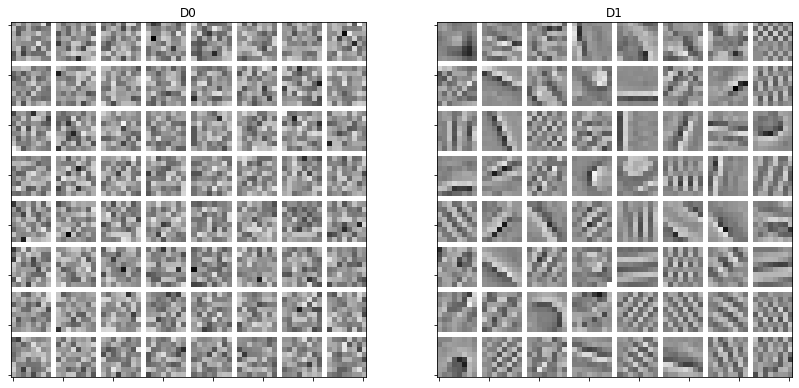

In [13]:
D1 = D1.squeeze()
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D0), title='D0', fig=fig)
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D1), title='D1', fig=fig)
fig.show()

Plot functional value and residuals.

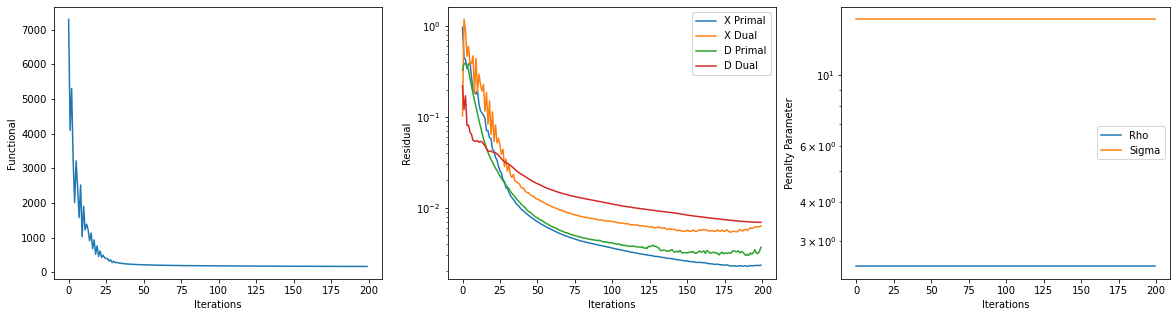

In [14]:
itsx = xstep.getitstat()
itsd = dstep.getitstat()
fig = plot.figure(figsize=(20, 5))
plot.subplot(1, 3, 1)
plot.plot(itsx.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.subplot(1, 3, 2)
plot.plot(np.vstack((itsx.PrimalRsdl, itsx.DualRsdl, itsd.PrimalRsdl,
          itsd.DualRsdl)).T, ptyp='semilogy', xlbl='Iterations',
          ylbl='Residual', lgnd=['X Primal', 'X Dual', 'D Primal', 'D Dual'],
          fig=fig)
plot.subplot(1, 3, 3)
plot.plot(np.vstack((itsx.Rho, itsd.Rho)).T,  xlbl='Iterations',
          ylbl='Penalty Parameter', ptyp='semilogy', lgnd=['Rho', 'Sigma'],
          fig=fig)
fig.show()